In [1]:
import principal_portfolios as pp
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from functools import reduce

In [2]:
data_to_read_address = "data/MSFX.xlsx"
fx_ms_df = pd.read_excel(data_to_read_address)

dfs = []

# Loop through the dataframe, two columns at a time (one for date, one for value)
for i in range(0, len(fx_ms_df.columns), 2):
    date_col = fx_ms_df.columns[i]
    value_col = fx_ms_df.columns[i + 1]
    
    # Rename the columns for clarity
    instrument_name = date_col.replace(' Index', '')
    
    # Create a new dataframe for the current instrument
    temp_df = fx_ms_df[[date_col, value_col]].copy()
    temp_df.columns = ['date', instrument_name]
    
    # Remove rows where the date is NaT or NaN in both columns
    temp_df = temp_df.dropna(subset=['date', instrument_name])
    
    # Append the dataframe to the list
    dfs.append(temp_df)

# Perform an inner join on the 'date' column for all dataframes
merged_df = reduce(lambda left, right: pd.merge(left, right, on='date', how='inner'), dfs)

# Remove any remaining rows with NaT or NaN after merging
merged_df.dropna(inplace=True)
merged_df

In [5]:
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Step 2: Set 'Date' as the index to enable resampling
merged_df.set_index('date', inplace=True)

# Step 3: Resample to get the last price of each month (monthly frequency 'M')
monthly_prices = merged_df.resample('M').last()

# Step 4: Calculate the monthly returns for each column (except 'Date')
monthly_returns = monthly_prices.pct_change() * 100

# Step 5: Reset the index to have 'Date' as a column again
monthly_returns.reset_index(inplace=True)
monthly_returns.dropna(inplace=True)

In [6]:
corr_matrix = monthly_returns.iloc[:,1:].corr()
to_drop = []

# Iterate over the columns of the correlation matrix
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.98 or corr_matrix.iloc[i, j] < -0.98:
            colname = corr_matrix.columns[j]
            if colname not in to_drop:
                to_drop.append(colname)

# Now drop the identified columns from the dataframe, keeping only the first
filtered_corr_matrix = corr_matrix.drop(columns=to_drop, index=to_drop)
columns_to_keep = filtered_corr_matrix.columns.to_list()

In [9]:
print(len(columns_to_keep))
columns_to_keep

33


In [11]:
processed_df = monthly_returns[['date']+columns_to_keep]
basket_portfolios = processed_df.iloc[:,-5:]
basket_portfolios.insert(0, 'date', processed_df['date'])

dict_keys(['fx_ms_portfolio_momentum_monthly'])
dict_keys(['realized_returns_df', 'sharpe_df', 'pp_realized_mean_df', 'pp_expected_mean_df', 'pep_realized_mean_df', 'pep_expected_mean_df', 'pap_realized_mean_df', 'pap_expected_mean_df'])
return_of_simple_factor          -0.033502
realized_return_of_first_n_PP     0.015733
realized_return_of_first_n_PEP   -0.058981
realized_return_of_first_n_PAP    0.514496
realized_return_of_1_PP          -0.205011
realized_return_of_1_PEP         -0.192642
realized_return_of_2_PP          -0.076718
realized_return_of_2_PEP          0.148953
realized_return_of_3_PP           0.406496
realized_return_of_3_PEP         -0.330581
realized_return_of_4_PP           0.030454
realized_return_of_4_PEP          0.064597
realized_return_of_5_PP           0.182023
realized_return_of_5_PEP          0.060925
realized_return_of_1_PAP          0.039553
realized_return_of_2_PAP          0.713394
PEP and PAP 1-n                   0.315972
dtype: float64


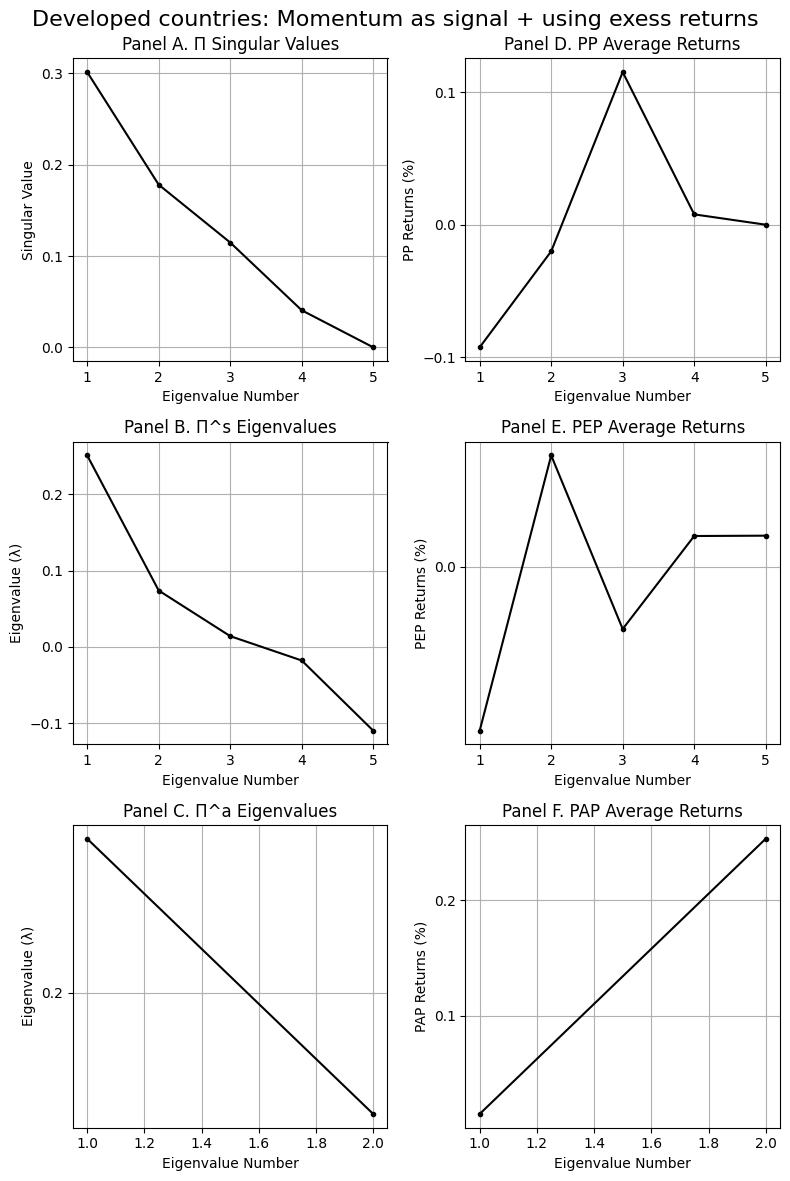

In [23]:
starting_year_to_filter = 1996
end_year_to_filter = 2024
number_of_lookback_periods = 120
number_of_PPs_to_consider = 4
number_of_PEPs_to_consider = 4
number_of_PAPs_to_consider = 2
output_dict_momentum = {}


basket_portfolios['date'] = pp.convert_date_column_for_monthly_data(basket_portfolios)
signal_df = pp.build_signal_df_for_1month_momentum(basket_portfolios)



portfolios_key = "fx_ms_portfolio_momentum_monthly"
output_dict_momentum[portfolios_key] = pp.build_PP(basket_portfolios,signal_df,
                                                                   number_of_lookback_periods,starting_year_to_filter,end_year_to_filter,
                                                                   factor_data_monthly=None, number_of_PPs_to_consider=number_of_PPs_to_consider,
                                                                   number_of_PEPs_to_consider=number_of_PEPs_to_consider, 
                                                                   number_of_PAPs_to_consider= number_of_PAPs_to_consider)

# I calculate the results for all datasets. the results are stored in this dictionay.
print(output_dict_momentum.keys())
'''
Every value of this dictionary is itself another dictionary.
For instance the key 'sharpe_df' can be used to access the sharp values of this set of results.
'''
print(output_dict_momentum[portfolios_key].keys())
print(output_dict_momentum[portfolios_key]["sharpe_df"])

number_of_portfolios = basket_portfolios.shape[1]
title = 'Developed countries: Momentum as signal + using exess returns'

pp.singular_values_vs_realized_returns_graph(output_dict_momentum, portfolios_key, number_of_portfolios, title)

In [24]:
output_dict_momentum[portfolios_key]['realized_returns_df']

,return_of_simple_factor,realized_return_of_first_n_PP,expected_return_of_first_n_PP,realized_return_of_first_n_PEP,expected_return_of_first_n_PEP,realized_return_of_first_n_PAP,expected_return_of_first_n_PAP,realized_return_of_1_PP,expected_return_of_1_PP,realized_return_of_1_PEP,...,expected_return_of_4_PEP,realized_return_of_5_PP,expected_return_of_5_PP,realized_return_of_5_PEP,expected_return_of_5_PEP,realized_return_of_1_PAP,expected_return_of_1_PAP,realized_return_of_2_PAP,expected_return_of_2_PAP,PEP and PAP 1-n
date,,,,,,,,,,,,,,,,,,,,,
2013-01-31,0.017727,0.436647,0.815947,0.004432,0.642312,0.307642,0.435345,-0.085174,0.489345,0.037419,...,6.815027e-03,-2.782949e-17,5.650555e-17,-4.801971e-16,-8.526002e-17,0.739650,0.303087,-0.124366,0.132257,0.117262
2013-02-28,-1.754719,0.035120,0.828920,-0.438680,0.632892,0.619115,0.459158,-0.863092,0.486421,-0.953271,...,1.143189e-02,-3.844600e-16,7.405472e-17,1.214837e-15,-2.230781e-17,0.868733,0.321037,0.369497,0.138121,0.012185
2013-03-31,-2.049676,-0.356804,0.799933,-0.512419,0.579402,1.392474,0.472782,-3.470820,0.471414,-4.633482,...,6.072423e-03,-6.553914e-17,5.562196e-17,6.015501e-16,-5.190715e-17,2.539261,0.335654,0.245687,0.137128,0.264521
2013-04-30,-7.583635,-1.563074,0.753312,-1.895909,0.552405,-0.243934,0.463580,-2.700909,0.423063,-3.115164,...,1.512861e-02,2.220464e-16,2.158498e-17,-3.371090e-16,-1.705521e-17,-0.338176,0.342727,-0.149693,0.120854,-1.039176
2013-05-31,1.685943,0.754190,0.630777,0.052994,0.437063,1.053704,0.409779,0.479197,0.324885,0.823123,...,-5.046521e-17,1.711219e-15,2.648647e-17,1.473968e+00,-8.502233e-03,-0.009393,0.297498,2.116801,0.112281,0.420541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30,-0.560661,-0.087804,0.677028,-0.098100,0.337016,-0.156852,0.364677,-0.634410,0.278638,-0.491164,...,-1.126009e-02,-1.520760e-16,6.412160e-18,-1.682600e-01,-2.208097e-01,-0.243445,0.267067,-0.070260,0.097610,-0.107707
2022-07-31,2.883178,0.103096,0.695557,0.721757,0.351082,-0.757850,0.351623,0.267413,0.273505,0.928791,...,-1.182960e-02,1.498647e-15,1.237211e-17,-3.849813e-03,-2.229583e-01,-1.189621,0.265225,-0.326078,0.086397,0.077472
2022-08-31,-2.422195,-0.487936,0.720179,-0.619657,0.315314,-0.521327,0.365945,-0.884589,0.304686,-1.178211,...,-1.614072e-02,1.652026e-15,2.977654e-17,5.643251e-02,-2.370918e-01,-1.115538,0.293971,0.072885,0.071974,-0.504784


In [32]:
pp.calculate_sharpe_ratio(basket_portfolios.iloc[121:,1:].mean(axis=1)) * math.sqrt(12)

0.09778131301178027

In [29]:
basket_portfolios.iloc[121:,1:].apply(lambda col: pp.calculate_sharpe_ratio(col)) * math.sqrt(12)

MSCEEFXU     0.087849
MSCECARU    -0.049862
MSCEQSIU     0.261062
MSCERERU    -0.164025
MSCEPOSU     0.201112
dtype: float64